### System Behavior Analysis & Risk Attribution

In [5]:
import json
import pandas as pd

with open(r"C:\Users\mdumiseni\OneDrive\Documents\data science assignements\data-science-portfolio\data_cleaning\outputs\pfaf_bdst_v1_cards.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.json_normalize(data)

print(df.columns)
print(df.shape)


Index(['uncertainty_and_disclaimer', 'identity.scientific_name',
       'identity.family', 'use_profile.edibility_rating',
       'use_profile.edibility_band', 'use_profile.medicinal_rating',
       'use_profile.medicinal_band', 'use_profile.quadrant',
       'use_profile.quadrant_label', 'risk_badge.bdst_risk_level',
       'risk_badge.risk_label', 'rationale.rules_triggered',
       'hazards.hazard_text_present', 'hazards.hazard_tier',
       'hazards.hazard_keyword_matches.H2',
       'hazards.hazard_keyword_matches.H1',
       'hazards.uncategorized_hazard_notes', 'hazards.hazard_notes_excerpt',
       'bioactivity_flags.bioactivity_risk_level',
       'bioactivity_flags.bioactivity_triggers',
       'debug.normalized_props_tokens', 'debug.normalized_hazards_text'],
      dtype='object')
(14283, 22)


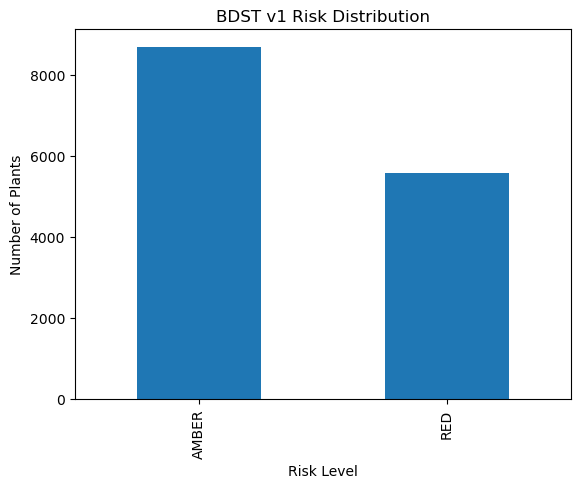

In [7]:
# Risk Distribution 
import matplotlib.pyplot as plt

risk_counts = df["risk_badge.bdst_risk_level"].value_counts()

plt.figure()
risk_counts.plot(kind="bar")
plt.title("BDST v1 Risk Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Number of Plants")
plt.show()


**Interpretation**

BDST v1 assigns no plants to GREEN risk. This is a deliberate design outcome, reflecting:
- the medicinal bias of the PFAF dataset,
- the prevalence of hazard documentation,
- and the system’s conservative, safety-first philosophy.

AMBER represents uncertainty or moderate caution, while RED reflects explicit or high-confidence risk signals.


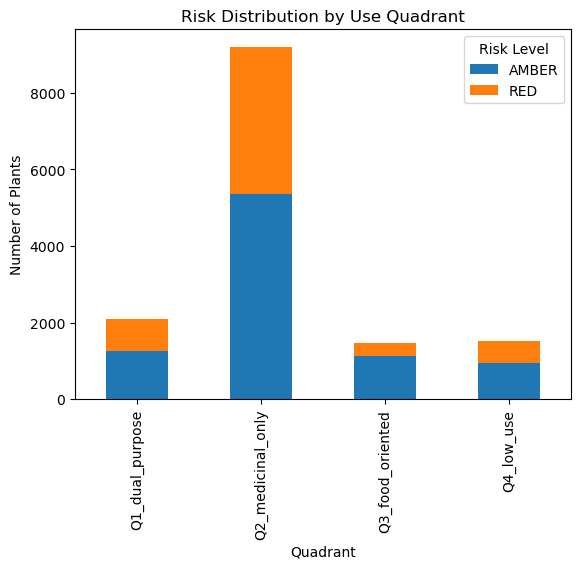

In [11]:
# Quadrant × Risk heatmap
pivot = (
    df
    .groupby(["use_profile.quadrant", "risk_badge.bdst_risk_level"])
    .size()
    .unstack(fill_value=0)
)

pivot.plot(kind="bar", stacked=True)
plt.title("Risk Distribution by Use Quadrant")
plt.xlabel("Quadrant")
plt.ylabel("Number of Plants")
plt.legend(title="Risk Level")
plt.show()



**Interpretation**

Medicinal-only plants (Q2) dominate both AMBER and RED classifications, confirming that
medicinal relevance does not imply safety. Food-oriented plants (Q3) form the smallest
risk-bearing group, validating the quadrant-based separation used in BDST.

This plot demonstrates that risk is strongly mediated by *use context*, not just hazard text.


In [12]:
# Hazard tier vs final risk (rule behavior check)
df["hazard_tier"] = df["hazards.hazard_tier"]


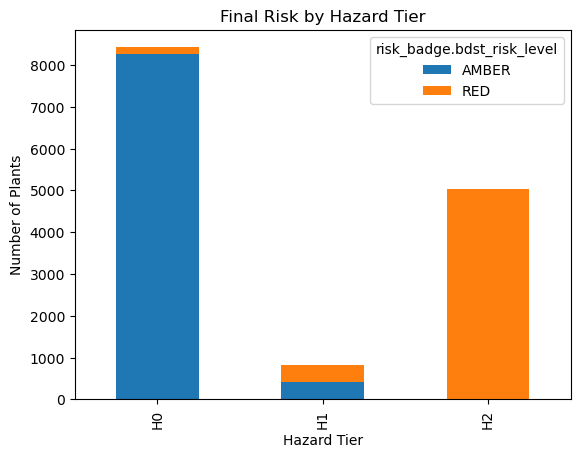

In [13]:
pivot_hazard = (
    df
    .groupby(["hazard_tier", "risk_badge.bdst_risk_level"])
    .size()
    .unstack(fill_value=0)
)

pivot_hazard.plot(kind="bar", stacked=True)
plt.title("Final Risk by Hazard Tier")
plt.xlabel("Hazard Tier")
plt.ylabel("Number of Plants")
plt.show()


**Interpretation**

While H2 hazards predominantly map to RED risk, plants with H0 hazard tier still receive
AMBER classifications. This reflects BDST’s treatment of undocumented or ambiguous hazard
information as uncertainty rather than safety.

The system avoids equating lack of known hazards with low risk.


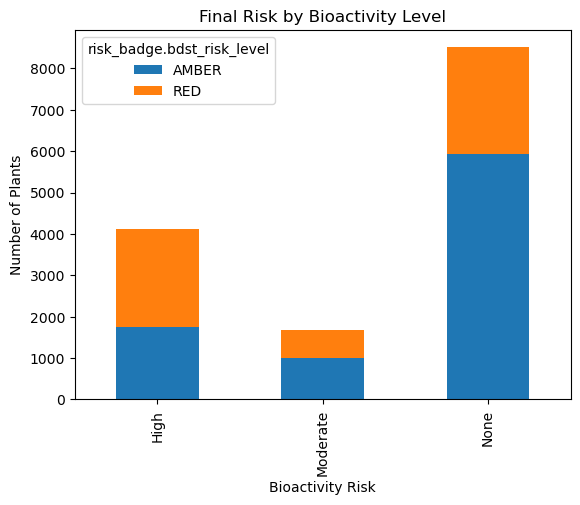

In [14]:
# Bioactivity risk vs final risk (pharmacology alignment)
pivot_bio = (
    df
    .groupby(["bioactivity_flags.bioactivity_risk_level", "risk_badge.bdst_risk_level"])
    .size()
    .unstack(fill_value=0)
)

pivot_bio.plot(kind="bar", stacked=True)
plt.title("Final Risk by Bioactivity Level")
plt.xlabel("Bioactivity Risk")
plt.ylabel("Number of Plants")
plt.show()


**Interpretation**

Plants with high-risk bioactivity signals are disproportionately classified as RED, indicating
effective escalation of pharmacologically potent properties. Moderate bioactivity is largely
associated with AMBER risk, reflecting cautious interpretation rather than prohibition.

This supports the validity of the bioactivity token normalization and escalation logic.


In [15]:
# Rule frequency analysis
rules_df = df[["rationale.rules_triggered"]].explode("rationale.rules_triggered")
rules_df = rules_df.dropna()


In [16]:
rule_counts = rules_df["rationale.rules_triggered"].value_counts()

print(rule_counts.head(15))


rationale.rules_triggered
base_risk_from_hazards:H0               8419
HZ_UNCATEGORIZED_MIN_AMBER              8419
base_risk_from_hazards:H2               5041
ESC_01_high_risk_bioactivity            4110
ESC_02_medicinal_only_high_medicinal    1082
base_risk_from_hazards:H1                823
Name: count, dtype: int64


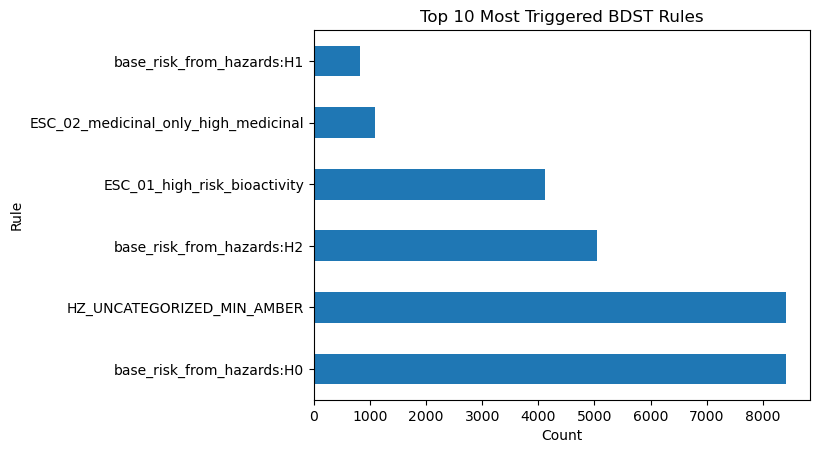

In [17]:
rule_counts.head(10).plot(kind="barh")
plt.title("Top 10 Most Triggered BDST Rules")
plt.xlabel("Count")
plt.ylabel("Rule")
plt.show()


**Interpretation**

The most frequently triggered rules relate to:
- base hazard classification,
- uncertainty due to uncategorized hazard notes,
- and medicinal-only use profiles.

This indicates that BDST risk assessments are driven primarily by documentation uncertainty
and medicinal context, rather than rare extreme hazards.


+ The identical frequency of the base_risk_from_hazards:H0 and HZ_UNCATEGORIZED_MIN_AMBER rules reflects a deliberate design choice in BDST v1. 
+ Plants lacking explicit hazard keywords (H0) nevertheless often contain hazard-related text that is vague or non-standard. 
+ Rather than treating such cases as safe, the system enforces a minimum AMBER classification to surface uncertainty and discourage overconfidence.